In [32]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

C:\Users\Dawit\AppData\Local\Temp\ipykernel_5068\2867026071.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [35]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538521,72.598899,71.292311,71.545897,135480400
2020-01-03,71.833298,72.594063,71.608692,71.765674,146322800
2020-01-06,72.405663,72.444306,70.702997,70.954173,118387200
2020-01-07,72.065147,72.671341,71.845369,72.415337,108872000
2020-01-08,73.224434,73.526326,71.768109,71.768109,132079200
...,...,...,...,...,...
2025-08-22,227.759995,229.089996,225.410004,226.169998,42477800
2025-08-25,227.160004,229.300003,226.229996,226.479996,30983100


<Axes: xlabel='Date'>

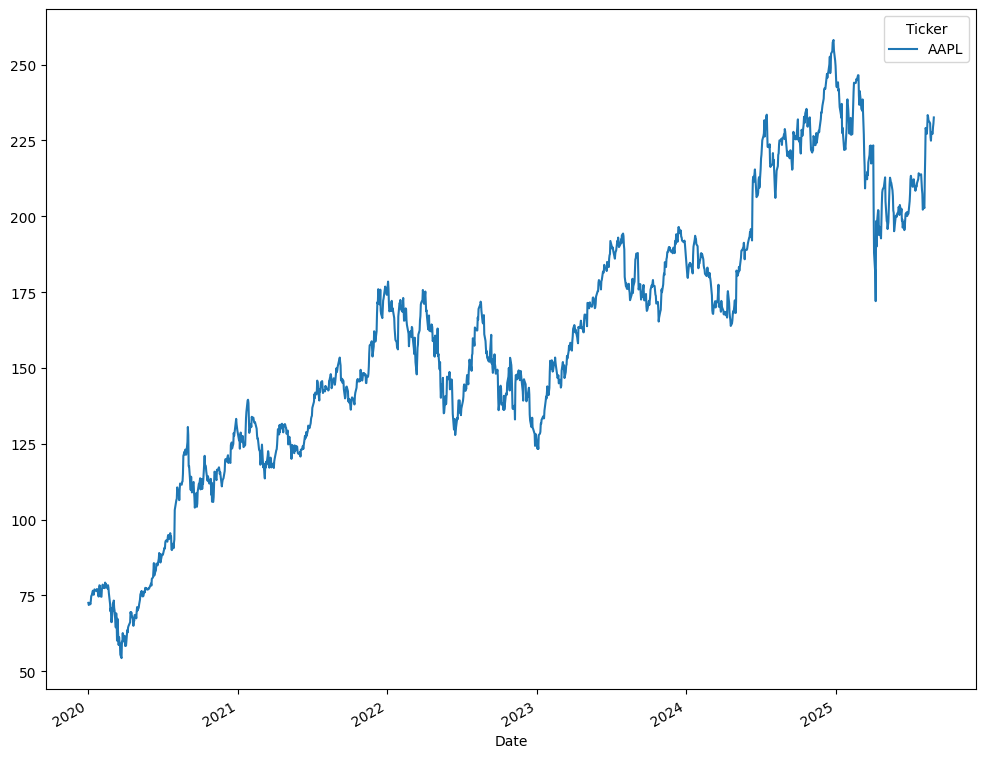

In [36]:
df.Close.plot(figsize=(12, 10))

In [37]:
scaler = StandardScaler()
df["Close"] = scaler.fit_transform(df['Close'])
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.933594
2020-01-03,-1.949319
2020-01-06,-1.936556
2020-01-07,-1.944149
2020-01-08,-1.918299
...,...
2025-08-22,1.527585
2025-08-25,1.514206
2025-08-26,1.562147


In [38]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])
data = np.array(data)


In [39]:
data

array([[[-1.93359356],
        [-1.94931885],
        [-1.93655608],
        ...,
        [-1.82578716],
        [-1.78481532],
        [-1.79739266]],

       [[-1.94931885],
        [-1.93655608],
        [-1.944149  ],
        ...,
        [-1.78481532],
        [-1.79739266],
        [-1.79696106]],

       [[-1.93655608],
        [-1.944149  ],
        [-1.91829885],
        ...,
        [-1.79739266],
        [-1.79696106],
        [-1.82908006]],

       ...,

       [[ 1.10643533],
        [ 1.12982209],
        [ 1.12670374],
        ...,
        [ 1.46381137],
        [ 1.52758458],
        [ 1.51420579]],

       [[ 1.12982209],
        [ 1.12670374],
        [ 1.15254028],
        ...,
        [ 1.52758458],
        [ 1.51420579],
        [ 1.56214704]],

       [[ 1.12670374],
        [ 1.15254028],
        [ 1.18149516],
        ...,
        [ 1.51420579],
        [ 1.56214704],
        [ 1.58845924]]], shape=(1392, 30, 1))

In [40]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)


In [41]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out
    

In [42]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [43]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [44]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.7435676455497742
25 0.012012016028165817
50 0.005963417701423168
75 0.005304715596139431
100 0.004960857797414064
125 0.004639667924493551
150 0.004338851198554039
175 0.004073473159223795


In [45]:
model.eval()
y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())



In [57]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])


In [47]:
train_rmse

2.7877495288848877

In [48]:
test_rmse

5.455212593078613

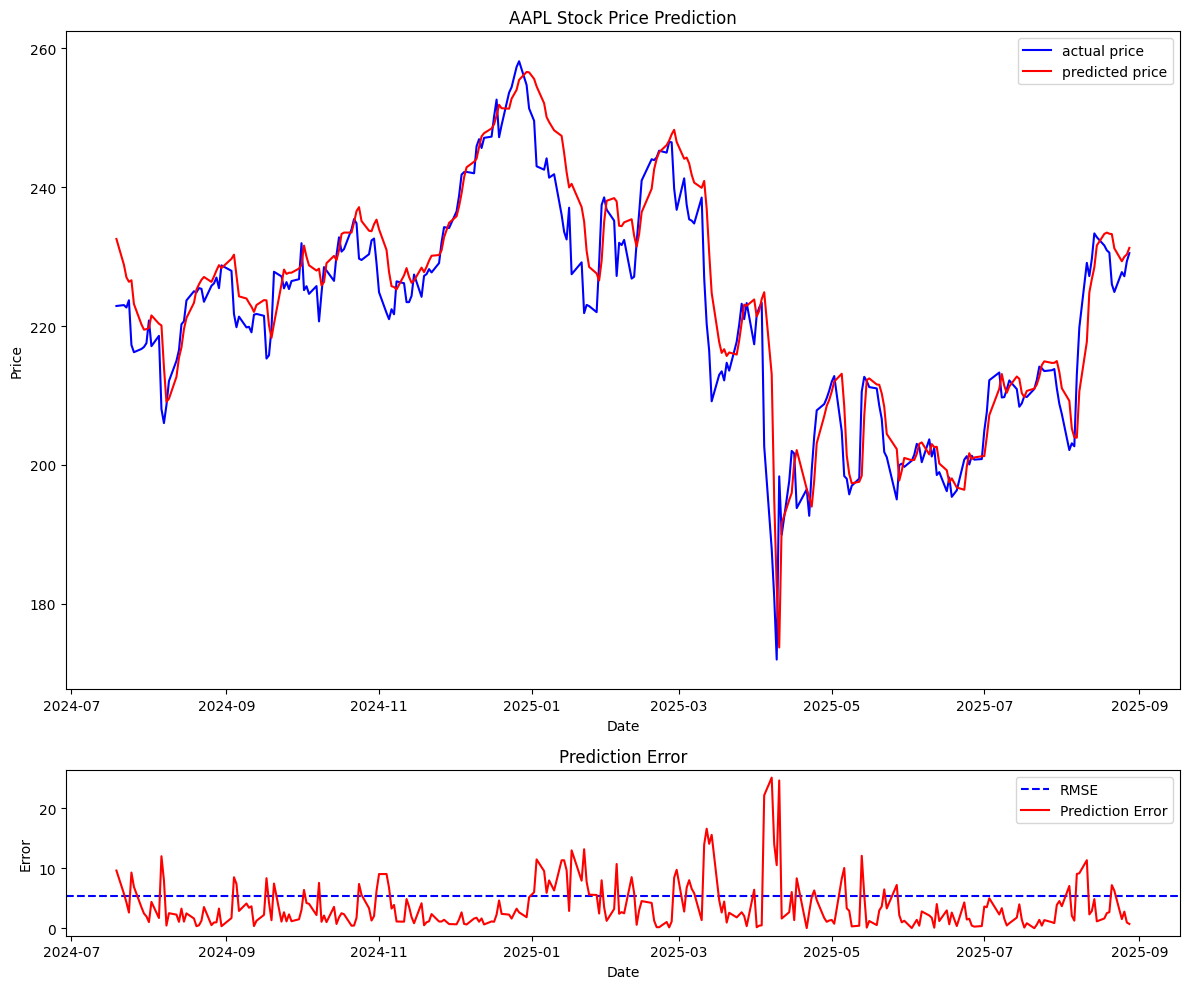

In [56]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

axl = fig.add_subplot(gs[:3, 0])
axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'actual price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'red', label = 'predicted price')

axl.legend()

plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()